# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
!ls /input

img_align_celeba  mnist


In [3]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# floyd run --mode jupyter --env tensorflow-1.2 --gpu --data R5KrjnANiKVhLWAkpXhNBe
#data_dir = '../../../dcgan-input'
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
#helper.download_extract('celeba', data_dir)

Found mnist Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

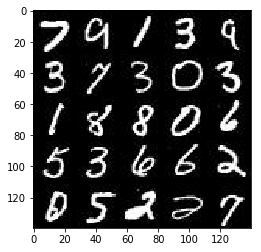

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

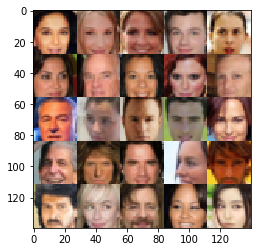

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='input_z')
    # TODO: Implement Function
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/local/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/local/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'F

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False, alpha=0.2, print_shapes = False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        if print_shapes:
            print(x1.get_shape())
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        if print_shapes:
            print(x2.get_shape())
            print(relu2.get_shape())
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        if print_shapes:
            print(x3.get_shape())
            print(relu3.get_shape())
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        if print_shapes:
            print(out.get_shape())
            print(logits.get_shape())
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True, reuse=False, alpha=0.2, print_shapes = False):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    The function should return the generated 28 x 28 x out_channel_dim images.
    """
    if print_shapes:
        print(z.get_shape())
    if print_shapes:
        print(out_channel_dim)
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7* 7* 256)
        if print_shapes:
            print('x1 ', x1.get_shape())
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        if print_shapes:
            print(x1.get_shape())
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding="SAME")
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        if print_shapes:
            print(x2.get_shape())
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        if print_shapes:
            print(x3.get_shape())
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='SAME')
        if print_shapes:
            print(logits.get_shape())
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smoothening_factor = 0.1

    g_model = generator(input_z, out_channel_dim, alpha=alpha, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)* (1 - smoothening_factor)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss    
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
#define the model, this idea is borowed from the class lecture
class GAN:
    def __init__(self, image_width, image_height, image_channels, z_dim, learning_rate, alpha=0.2, beta1=0.5):
        #tf.reset_default_graph()
        """
        "Clears the default graph stack and resets the global default graph"
        The docs also say:
        "The default graph is a property of the current thread. This function applies only to the current thread. Calling this
        function while a tf.Session or tf.InteractiveSession is active will result in undefined behavior. Using any previously 
        created tf.Operation or tf.Tensor objects after calling this function will result in undefined behavior."
        """
        
        self.input_real, self.input_z, self.learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, image_channels, alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)
        


In [14]:

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Create the network
    # Set the image dimensions
    _, image_width, image_height, image_channels = data_shape    
    net = GAN(image_width, image_height, image_channels, z_dim, learning_rate, alpha=alpha, beta1=beta1)
    
    steps = 0
    show_every = 100
    print_every = 10
    samples, losses = [], []
    n_images_to_print = 25    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):

                steps += 1

                # Multiply batch_images by 2.0 since the dataset ranges from -0.5 to 0.5
                batch_images = batch_images*2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                x = batch_images
                # print('batch_images => ', batch_images.shape)
                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Step:{} Epoch {}/{}...".format(steps, epoch_i, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images_to_print, net.input_z, image_channels, data_image_mode)

        #saver.save(sess, './checkpoints/generator.ckpt')                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step:10 Epoch 0/2... Discriminator Loss: 0.5095... Generator Loss: 2.4033
Step:20 Epoch 0/2... Discriminator Loss: 1.0634... Generator Loss: 1.0354
Step:30 Epoch 0/2... Discriminator Loss: 1.7111... Generator Loss: 5.1549
Step:40 Epoch 0/2... Discriminator Loss: 1.2635... Generator Loss: 0.8546
Step:50 Epoch 0/2... Discriminator Loss: 0.8981... Generator Loss: 2.0346
Step:60 Epoch 0/2... Discriminator Loss: 1.1034... Generator Loss: 0.8008
Step:70 Epoch 0/2... Discriminator Loss: 0.7863... Generator Loss: 2.1714
Step:80 Epoch 0/2... Discriminator Loss: 0.9400... Generator Loss: 3.0446
Step:90 Epoch 0/2... Discriminator Loss: 1.1068... Generator Loss: 0.8253
Step:100 Epoch 0/2... Discriminator Loss: 1.2073... Generator Loss: 0.6094


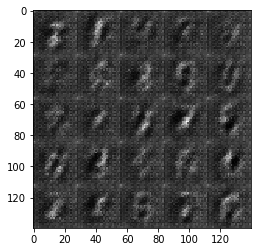

Step:110 Epoch 0/2... Discriminator Loss: 0.7980... Generator Loss: 1.3451
Step:120 Epoch 0/2... Discriminator Loss: 2.0388... Generator Loss: 4.8256
Step:130 Epoch 0/2... Discriminator Loss: 0.8819... Generator Loss: 1.0544
Step:140 Epoch 0/2... Discriminator Loss: 0.8014... Generator Loss: 1.6005
Step:150 Epoch 0/2... Discriminator Loss: 0.9226... Generator Loss: 1.8083
Step:160 Epoch 0/2... Discriminator Loss: 0.7537... Generator Loss: 1.8866
Step:170 Epoch 0/2... Discriminator Loss: 0.8265... Generator Loss: 1.0806
Step:180 Epoch 0/2... Discriminator Loss: 0.7334... Generator Loss: 1.8429
Step:190 Epoch 0/2... Discriminator Loss: 1.1986... Generator Loss: 0.6770
Step:200 Epoch 0/2... Discriminator Loss: 1.1936... Generator Loss: 0.6895


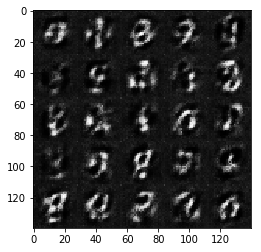

Step:210 Epoch 0/2... Discriminator Loss: 0.7967... Generator Loss: 1.2672
Step:220 Epoch 0/2... Discriminator Loss: 0.7719... Generator Loss: 1.4420
Step:230 Epoch 0/2... Discriminator Loss: 0.8132... Generator Loss: 1.3093
Step:240 Epoch 0/2... Discriminator Loss: 1.1485... Generator Loss: 0.6787
Step:250 Epoch 0/2... Discriminator Loss: 0.7253... Generator Loss: 1.3472
Step:260 Epoch 0/2... Discriminator Loss: 0.7803... Generator Loss: 1.2785
Step:270 Epoch 0/2... Discriminator Loss: 1.0160... Generator Loss: 3.2180
Step:280 Epoch 0/2... Discriminator Loss: 0.8254... Generator Loss: 2.3912
Step:290 Epoch 0/2... Discriminator Loss: 0.8637... Generator Loss: 1.0721
Step:300 Epoch 0/2... Discriminator Loss: 1.1954... Generator Loss: 0.6121


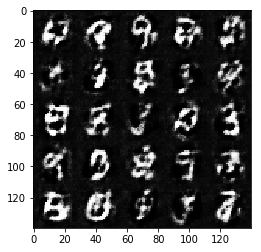

Step:310 Epoch 0/2... Discriminator Loss: 0.7537... Generator Loss: 1.2870
Step:320 Epoch 0/2... Discriminator Loss: 0.8418... Generator Loss: 1.0398
Step:330 Epoch 0/2... Discriminator Loss: 0.9138... Generator Loss: 0.9301
Step:340 Epoch 0/2... Discriminator Loss: 1.0296... Generator Loss: 0.7757
Step:350 Epoch 0/2... Discriminator Loss: 0.7676... Generator Loss: 1.4519
Step:360 Epoch 0/2... Discriminator Loss: 1.0521... Generator Loss: 0.7469
Step:370 Epoch 0/2... Discriminator Loss: 0.7444... Generator Loss: 1.8218
Step:380 Epoch 0/2... Discriminator Loss: 0.7868... Generator Loss: 1.2235
Step:390 Epoch 0/2... Discriminator Loss: 0.6724... Generator Loss: 2.2922
Step:400 Epoch 0/2... Discriminator Loss: 0.8342... Generator Loss: 1.1123


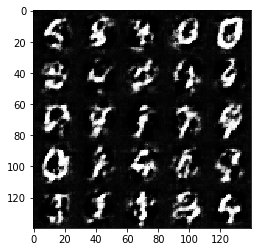

Step:410 Epoch 0/2... Discriminator Loss: 0.6675... Generator Loss: 1.9520
Step:420 Epoch 0/2... Discriminator Loss: 0.7736... Generator Loss: 1.2337
Step:430 Epoch 0/2... Discriminator Loss: 0.8685... Generator Loss: 1.0222
Step:440 Epoch 0/2... Discriminator Loss: 0.9196... Generator Loss: 2.5386
Step:450 Epoch 0/2... Discriminator Loss: 0.8023... Generator Loss: 1.0976
Step:460 Epoch 0/2... Discriminator Loss: 0.8249... Generator Loss: 1.3157
Step:470 Epoch 0/2... Discriminator Loss: 0.7380... Generator Loss: 2.0071
Step:480 Epoch 0/2... Discriminator Loss: 1.2266... Generator Loss: 0.7197
Step:490 Epoch 0/2... Discriminator Loss: 0.7547... Generator Loss: 1.2769
Step:500 Epoch 0/2... Discriminator Loss: 0.7796... Generator Loss: 2.2575


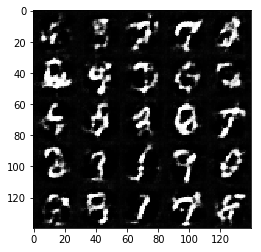

Step:510 Epoch 0/2... Discriminator Loss: 0.7571... Generator Loss: 1.4421
Step:520 Epoch 0/2... Discriminator Loss: 0.8127... Generator Loss: 1.1365
Step:530 Epoch 0/2... Discriminator Loss: 0.8478... Generator Loss: 1.4619
Step:540 Epoch 0/2... Discriminator Loss: 1.0354... Generator Loss: 0.8627
Step:550 Epoch 0/2... Discriminator Loss: 0.8454... Generator Loss: 1.1686
Step:560 Epoch 0/2... Discriminator Loss: 0.7857... Generator Loss: 1.3825
Step:570 Epoch 0/2... Discriminator Loss: 1.1501... Generator Loss: 2.9377
Step:580 Epoch 0/2... Discriminator Loss: 1.7066... Generator Loss: 0.3956
Step:590 Epoch 0/2... Discriminator Loss: 0.9473... Generator Loss: 0.9406
Step:600 Epoch 0/2... Discriminator Loss: 0.8630... Generator Loss: 1.0257


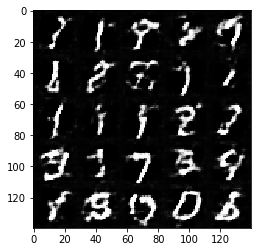

Step:610 Epoch 0/2... Discriminator Loss: 0.7942... Generator Loss: 1.5190
Step:620 Epoch 0/2... Discriminator Loss: 1.0974... Generator Loss: 0.7656
Step:630 Epoch 0/2... Discriminator Loss: 0.8280... Generator Loss: 1.2255
Step:640 Epoch 0/2... Discriminator Loss: 1.0826... Generator Loss: 0.7578
Step:650 Epoch 0/2... Discriminator Loss: 0.7922... Generator Loss: 1.7011
Step:660 Epoch 0/2... Discriminator Loss: 1.0746... Generator Loss: 2.2395
Step:670 Epoch 0/2... Discriminator Loss: 1.0673... Generator Loss: 0.7843
Step:680 Epoch 0/2... Discriminator Loss: 0.7795... Generator Loss: 1.2358
Step:690 Epoch 0/2... Discriminator Loss: 0.8578... Generator Loss: 1.5625
Step:700 Epoch 0/2... Discriminator Loss: 0.9586... Generator Loss: 1.4511


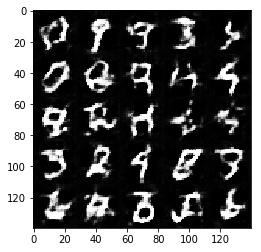

Step:710 Epoch 0/2... Discriminator Loss: 1.1379... Generator Loss: 0.7231
Step:720 Epoch 0/2... Discriminator Loss: 0.8267... Generator Loss: 1.1719
Step:730 Epoch 0/2... Discriminator Loss: 0.7474... Generator Loss: 1.3482
Step:740 Epoch 0/2... Discriminator Loss: 1.2660... Generator Loss: 0.5892
Step:750 Epoch 0/2... Discriminator Loss: 0.7804... Generator Loss: 1.4189
Step:760 Epoch 0/2... Discriminator Loss: 0.8412... Generator Loss: 2.2265
Step:770 Epoch 0/2... Discriminator Loss: 0.8922... Generator Loss: 1.0451
Step:780 Epoch 0/2... Discriminator Loss: 0.9796... Generator Loss: 0.9364
Step:790 Epoch 0/2... Discriminator Loss: 1.2105... Generator Loss: 0.6866
Step:800 Epoch 0/2... Discriminator Loss: 0.8918... Generator Loss: 1.2499


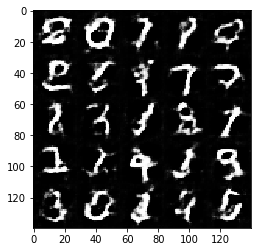

Step:810 Epoch 0/2... Discriminator Loss: 0.9722... Generator Loss: 2.3201
Step:820 Epoch 0/2... Discriminator Loss: 1.2336... Generator Loss: 0.6573
Step:830 Epoch 0/2... Discriminator Loss: 0.8268... Generator Loss: 1.3152
Step:840 Epoch 0/2... Discriminator Loss: 0.9982... Generator Loss: 0.9213
Step:850 Epoch 0/2... Discriminator Loss: 0.8500... Generator Loss: 1.0791
Step:860 Epoch 0/2... Discriminator Loss: 1.0232... Generator Loss: 0.8033
Step:870 Epoch 0/2... Discriminator Loss: 1.0597... Generator Loss: 0.7963
Step:880 Epoch 0/2... Discriminator Loss: 0.8747... Generator Loss: 1.8485
Step:890 Epoch 0/2... Discriminator Loss: 0.8343... Generator Loss: 1.5656
Step:900 Epoch 0/2... Discriminator Loss: 1.0561... Generator Loss: 0.7949


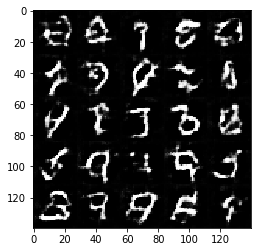

Step:910 Epoch 0/2... Discriminator Loss: 0.8575... Generator Loss: 1.7100
Step:920 Epoch 0/2... Discriminator Loss: 0.8472... Generator Loss: 1.0897
Step:930 Epoch 0/2... Discriminator Loss: 1.1512... Generator Loss: 0.7137
Step:940 Epoch 1/2... Discriminator Loss: 1.0778... Generator Loss: 0.7511
Step:950 Epoch 1/2... Discriminator Loss: 0.9586... Generator Loss: 0.9216
Step:960 Epoch 1/2... Discriminator Loss: 0.8733... Generator Loss: 1.0676
Step:970 Epoch 1/2... Discriminator Loss: 2.9917... Generator Loss: 0.1245
Step:980 Epoch 1/2... Discriminator Loss: 1.0125... Generator Loss: 2.1202
Step:990 Epoch 1/2... Discriminator Loss: 0.9864... Generator Loss: 0.9136
Step:1000 Epoch 1/2... Discriminator Loss: 0.9924... Generator Loss: 0.8982


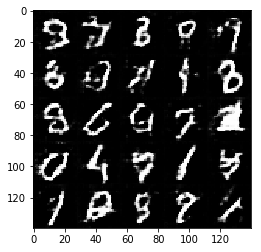

Step:1010 Epoch 1/2... Discriminator Loss: 0.7801... Generator Loss: 1.3031
Step:1020 Epoch 1/2... Discriminator Loss: 0.8940... Generator Loss: 1.0512
Step:1030 Epoch 1/2... Discriminator Loss: 1.3181... Generator Loss: 0.5379
Step:1040 Epoch 1/2... Discriminator Loss: 1.2077... Generator Loss: 0.6316
Step:1050 Epoch 1/2... Discriminator Loss: 1.2418... Generator Loss: 0.6343
Step:1060 Epoch 1/2... Discriminator Loss: 0.8065... Generator Loss: 1.1613
Step:1070 Epoch 1/2... Discriminator Loss: 1.3151... Generator Loss: 2.0093
Step:1080 Epoch 1/2... Discriminator Loss: 0.8205... Generator Loss: 1.3145
Step:1090 Epoch 1/2... Discriminator Loss: 0.8781... Generator Loss: 0.9962
Step:1100 Epoch 1/2... Discriminator Loss: 0.7973... Generator Loss: 1.2087


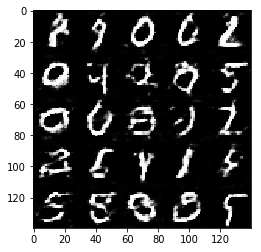

Step:1110 Epoch 1/2... Discriminator Loss: 0.7323... Generator Loss: 1.4306
Step:1120 Epoch 1/2... Discriminator Loss: 1.0251... Generator Loss: 0.8218
Step:1130 Epoch 1/2... Discriminator Loss: 1.4643... Generator Loss: 0.4596
Step:1140 Epoch 1/2... Discriminator Loss: 0.9160... Generator Loss: 1.3381
Step:1150 Epoch 1/2... Discriminator Loss: 0.9422... Generator Loss: 1.2227
Step:1160 Epoch 1/2... Discriminator Loss: 0.9517... Generator Loss: 1.0398
Step:1170 Epoch 1/2... Discriminator Loss: 0.8386... Generator Loss: 1.1004
Step:1180 Epoch 1/2... Discriminator Loss: 0.9970... Generator Loss: 0.8552
Step:1190 Epoch 1/2... Discriminator Loss: 1.0571... Generator Loss: 0.7764
Step:1200 Epoch 1/2... Discriminator Loss: 0.9995... Generator Loss: 0.8068


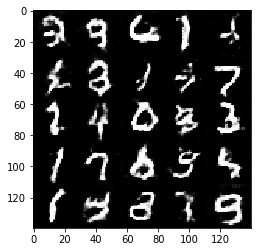

Step:1210 Epoch 1/2... Discriminator Loss: 0.8002... Generator Loss: 1.2093
Step:1220 Epoch 1/2... Discriminator Loss: 1.2845... Generator Loss: 0.5836
Step:1230 Epoch 1/2... Discriminator Loss: 0.9746... Generator Loss: 0.9677
Step:1240 Epoch 1/2... Discriminator Loss: 0.9679... Generator Loss: 0.9260
Step:1250 Epoch 1/2... Discriminator Loss: 0.7113... Generator Loss: 1.4815
Step:1260 Epoch 1/2... Discriminator Loss: 1.0666... Generator Loss: 0.7966
Step:1270 Epoch 1/2... Discriminator Loss: 0.7884... Generator Loss: 1.2523
Step:1280 Epoch 1/2... Discriminator Loss: 0.7984... Generator Loss: 1.2508
Step:1290 Epoch 1/2... Discriminator Loss: 1.0244... Generator Loss: 0.7756
Step:1300 Epoch 1/2... Discriminator Loss: 0.8826... Generator Loss: 1.0056


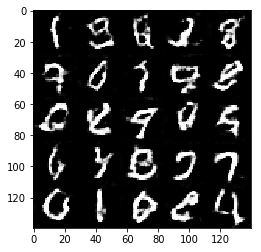

Step:1310 Epoch 1/2... Discriminator Loss: 0.7814... Generator Loss: 1.2906
Step:1320 Epoch 1/2... Discriminator Loss: 0.8358... Generator Loss: 1.0722
Step:1330 Epoch 1/2... Discriminator Loss: 0.9826... Generator Loss: 0.9061
Step:1340 Epoch 1/2... Discriminator Loss: 6.9922... Generator Loss: 9.0024
Step:1350 Epoch 1/2... Discriminator Loss: 0.9921... Generator Loss: 1.2225
Step:1360 Epoch 1/2... Discriminator Loss: 1.0585... Generator Loss: 0.9157
Step:1370 Epoch 1/2... Discriminator Loss: 1.2663... Generator Loss: 0.5952
Step:1380 Epoch 1/2... Discriminator Loss: 1.3228... Generator Loss: 0.5582
Step:1390 Epoch 1/2... Discriminator Loss: 0.8842... Generator Loss: 1.0581
Step:1400 Epoch 1/2... Discriminator Loss: 0.8963... Generator Loss: 0.9909


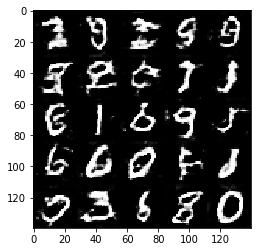

Step:1410 Epoch 1/2... Discriminator Loss: 0.7643... Generator Loss: 1.3084
Step:1420 Epoch 1/2... Discriminator Loss: 0.8554... Generator Loss: 1.0567
Step:1430 Epoch 1/2... Discriminator Loss: 0.9484... Generator Loss: 0.9211
Step:1440 Epoch 1/2... Discriminator Loss: 1.0405... Generator Loss: 0.8268
Step:1450 Epoch 1/2... Discriminator Loss: 0.7351... Generator Loss: 1.2786
Step:1460 Epoch 1/2... Discriminator Loss: 0.6771... Generator Loss: 2.0427
Step:1470 Epoch 1/2... Discriminator Loss: 1.1565... Generator Loss: 0.6818
Step:1480 Epoch 1/2... Discriminator Loss: 0.8502... Generator Loss: 1.0261
Step:1490 Epoch 1/2... Discriminator Loss: 3.3481... Generator Loss: 4.5707
Step:1500 Epoch 1/2... Discriminator Loss: 1.1073... Generator Loss: 0.8056


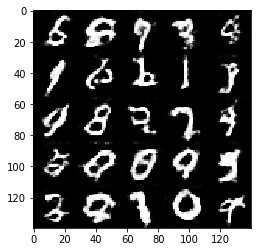

Step:1510 Epoch 1/2... Discriminator Loss: 1.0243... Generator Loss: 1.0033
Step:1520 Epoch 1/2... Discriminator Loss: 0.8549... Generator Loss: 1.2721
Step:1530 Epoch 1/2... Discriminator Loss: 1.1786... Generator Loss: 0.6845
Step:1540 Epoch 1/2... Discriminator Loss: 0.8221... Generator Loss: 1.2170
Step:1550 Epoch 1/2... Discriminator Loss: 0.7054... Generator Loss: 1.4423
Step:1560 Epoch 1/2... Discriminator Loss: 0.9537... Generator Loss: 0.9220
Step:1570 Epoch 1/2... Discriminator Loss: 0.7965... Generator Loss: 1.1447
Step:1580 Epoch 1/2... Discriminator Loss: 0.8937... Generator Loss: 1.0170
Step:1590 Epoch 1/2... Discriminator Loss: 0.8207... Generator Loss: 1.3509
Step:1600 Epoch 1/2... Discriminator Loss: 0.9941... Generator Loss: 0.8835


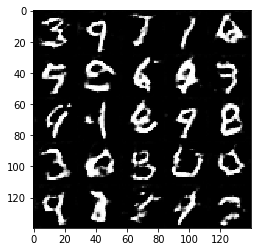

Step:1610 Epoch 1/2... Discriminator Loss: 0.9822... Generator Loss: 0.8719
Step:1620 Epoch 1/2... Discriminator Loss: 0.9831... Generator Loss: 0.8650
Step:1630 Epoch 1/2... Discriminator Loss: 0.7529... Generator Loss: 1.2677
Step:1640 Epoch 1/2... Discriminator Loss: 1.4194... Generator Loss: 2.6719
Step:1650 Epoch 1/2... Discriminator Loss: 1.0900... Generator Loss: 0.8012
Step:1660 Epoch 1/2... Discriminator Loss: 1.1529... Generator Loss: 1.9935
Step:1670 Epoch 1/2... Discriminator Loss: 1.0772... Generator Loss: 2.1476
Step:1680 Epoch 1/2... Discriminator Loss: 0.8840... Generator Loss: 1.9262
Step:1690 Epoch 1/2... Discriminator Loss: 0.9725... Generator Loss: 0.9107
Step:1700 Epoch 1/2... Discriminator Loss: 0.6621... Generator Loss: 1.5391


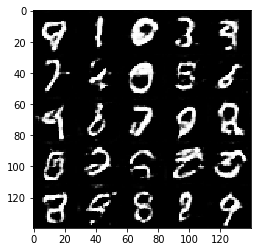

Step:1710 Epoch 1/2... Discriminator Loss: 0.7867... Generator Loss: 1.2002
Step:1720 Epoch 1/2... Discriminator Loss: 0.6865... Generator Loss: 1.5109
Step:1730 Epoch 1/2... Discriminator Loss: 0.7294... Generator Loss: 1.3858
Step:1740 Epoch 1/2... Discriminator Loss: 0.7651... Generator Loss: 1.9075
Step:1750 Epoch 1/2... Discriminator Loss: 0.8660... Generator Loss: 1.3408
Step:1760 Epoch 1/2... Discriminator Loss: 0.7567... Generator Loss: 1.5885
Step:1770 Epoch 1/2... Discriminator Loss: 0.6192... Generator Loss: 1.6685
Step:1780 Epoch 1/2... Discriminator Loss: 1.1750... Generator Loss: 0.6645
Step:1790 Epoch 1/2... Discriminator Loss: 0.9161... Generator Loss: 0.9719
Step:1800 Epoch 1/2... Discriminator Loss: 0.7670... Generator Loss: 1.2243


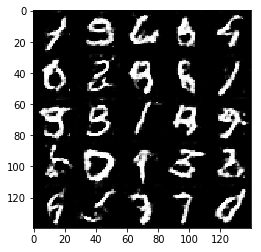

Step:1810 Epoch 1/2... Discriminator Loss: 0.7181... Generator Loss: 1.3690
Step:1820 Epoch 1/2... Discriminator Loss: 3.0516... Generator Loss: 0.1224
Step:1830 Epoch 1/2... Discriminator Loss: 1.2409... Generator Loss: 0.6243
Step:1840 Epoch 1/2... Discriminator Loss: 1.0281... Generator Loss: 0.8399
Step:1850 Epoch 1/2... Discriminator Loss: 0.7537... Generator Loss: 1.3339
Step:1860 Epoch 1/2... Discriminator Loss: 1.4323... Generator Loss: 0.5832
Step:1870 Epoch 1/2... Discriminator Loss: 0.8797... Generator Loss: 1.0079


In [15]:
z_dim = 256
learning_rate = 0.0002
batch_size = 64
alpha = 0.2
beta1 = 0.4

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step:10 Epoch 0/1... Discriminator Loss: 1.1739... Generator Loss: 0.7899
Step:20 Epoch 0/1... Discriminator Loss: 0.9641... Generator Loss: 1.0306
Step:30 Epoch 0/1... Discriminator Loss: 0.8443... Generator Loss: 1.1504
Step:40 Epoch 0/1... Discriminator Loss: 0.6172... Generator Loss: 1.8927
Step:50 Epoch 0/1... Discriminator Loss: 0.5698... Generator Loss: 5.4226
Step:60 Epoch 0/1... Discriminator Loss: 0.6291... Generator Loss: 2.0848
Step:70 Epoch 0/1... Discriminator Loss: 1.0243... Generator Loss: 6.7441
Step:80 Epoch 0/1... Discriminator Loss: 1.1361... Generator Loss: 0.8175
Step:90 Epoch 0/1... Discriminator Loss: 1.0059... Generator Loss: 1.1041
Step:100 Epoch 0/1... Discriminator Loss: 0.8822... Generator Loss: 1.5380


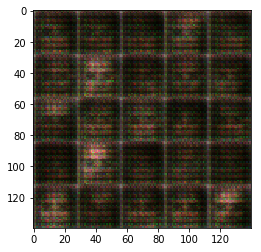

Step:110 Epoch 0/1... Discriminator Loss: 1.8465... Generator Loss: 5.6699
Step:120 Epoch 0/1... Discriminator Loss: 0.7298... Generator Loss: 1.4986
Step:130 Epoch 0/1... Discriminator Loss: 0.8132... Generator Loss: 3.5999
Step:140 Epoch 0/1... Discriminator Loss: 0.9771... Generator Loss: 3.1650
Step:150 Epoch 0/1... Discriminator Loss: 1.3110... Generator Loss: 0.6584
Step:160 Epoch 0/1... Discriminator Loss: 1.2036... Generator Loss: 0.7199
Step:170 Epoch 0/1... Discriminator Loss: 1.3614... Generator Loss: 0.5587
Step:180 Epoch 0/1... Discriminator Loss: 0.9745... Generator Loss: 1.8442
Step:190 Epoch 0/1... Discriminator Loss: 0.9222... Generator Loss: 0.9790
Step:200 Epoch 0/1... Discriminator Loss: 1.7464... Generator Loss: 0.3898


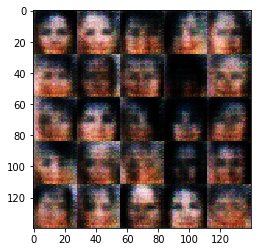

Step:210 Epoch 0/1... Discriminator Loss: 0.8973... Generator Loss: 1.1319
Step:220 Epoch 0/1... Discriminator Loss: 1.9756... Generator Loss: 0.2829
Step:230 Epoch 0/1... Discriminator Loss: 1.5259... Generator Loss: 0.5128
Step:240 Epoch 0/1... Discriminator Loss: 1.3746... Generator Loss: 0.5660
Step:250 Epoch 0/1... Discriminator Loss: 1.0093... Generator Loss: 0.9913
Step:260 Epoch 0/1... Discriminator Loss: 1.8371... Generator Loss: 0.3200
Step:270 Epoch 0/1... Discriminator Loss: 1.0716... Generator Loss: 2.1410
Step:280 Epoch 0/1... Discriminator Loss: 1.0584... Generator Loss: 0.9518
Step:290 Epoch 0/1... Discriminator Loss: 2.4370... Generator Loss: 4.6676
Step:300 Epoch 0/1... Discriminator Loss: 1.0138... Generator Loss: 0.8733


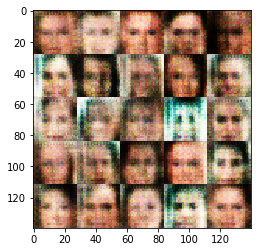

Step:310 Epoch 0/1... Discriminator Loss: 1.5190... Generator Loss: 0.4588
Step:320 Epoch 0/1... Discriminator Loss: 1.0844... Generator Loss: 0.9042
Step:330 Epoch 0/1... Discriminator Loss: 2.1362... Generator Loss: 0.2499
Step:340 Epoch 0/1... Discriminator Loss: 1.9569... Generator Loss: 0.2668
Step:350 Epoch 0/1... Discriminator Loss: 1.0192... Generator Loss: 1.1633
Step:360 Epoch 0/1... Discriminator Loss: 1.6014... Generator Loss: 0.4663
Step:370 Epoch 0/1... Discriminator Loss: 1.5395... Generator Loss: 0.4464
Step:380 Epoch 0/1... Discriminator Loss: 1.3933... Generator Loss: 0.5794
Step:390 Epoch 0/1... Discriminator Loss: 1.1506... Generator Loss: 0.9828
Step:400 Epoch 0/1... Discriminator Loss: 1.8815... Generator Loss: 0.2916


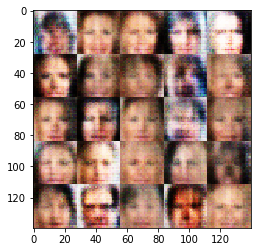

Step:410 Epoch 0/1... Discriminator Loss: 1.1348... Generator Loss: 0.9124
Step:420 Epoch 0/1... Discriminator Loss: 1.6566... Generator Loss: 0.4093
Step:430 Epoch 0/1... Discriminator Loss: 1.1278... Generator Loss: 0.7596
Step:440 Epoch 0/1... Discriminator Loss: 1.3085... Generator Loss: 0.6747
Step:450 Epoch 0/1... Discriminator Loss: 1.3637... Generator Loss: 0.5586
Step:460 Epoch 0/1... Discriminator Loss: 1.0297... Generator Loss: 1.1214
Step:470 Epoch 0/1... Discriminator Loss: 1.2089... Generator Loss: 1.7512
Step:480 Epoch 0/1... Discriminator Loss: 1.1378... Generator Loss: 1.1992
Step:490 Epoch 0/1... Discriminator Loss: 1.3877... Generator Loss: 0.5573
Step:500 Epoch 0/1... Discriminator Loss: 1.1064... Generator Loss: 1.0064


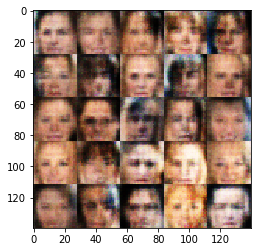

Step:510 Epoch 0/1... Discriminator Loss: 1.2684... Generator Loss: 0.7191
Step:520 Epoch 0/1... Discriminator Loss: 1.3125... Generator Loss: 1.9290
Step:530 Epoch 0/1... Discriminator Loss: 1.2417... Generator Loss: 0.7231
Step:540 Epoch 0/1... Discriminator Loss: 1.6146... Generator Loss: 2.2460
Step:550 Epoch 0/1... Discriminator Loss: 1.2009... Generator Loss: 0.7958
Step:560 Epoch 0/1... Discriminator Loss: 1.3306... Generator Loss: 0.5461
Step:570 Epoch 0/1... Discriminator Loss: 1.1798... Generator Loss: 0.8205
Step:580 Epoch 0/1... Discriminator Loss: 1.5981... Generator Loss: 0.4188
Step:590 Epoch 0/1... Discriminator Loss: 1.1675... Generator Loss: 1.5281
Step:600 Epoch 0/1... Discriminator Loss: 1.2946... Generator Loss: 1.8709


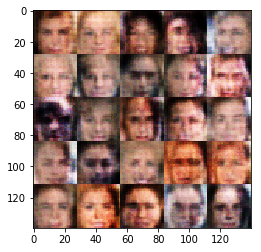

Step:610 Epoch 0/1... Discriminator Loss: 1.1766... Generator Loss: 0.7120
Step:620 Epoch 0/1... Discriminator Loss: 1.2431... Generator Loss: 0.6541
Step:630 Epoch 0/1... Discriminator Loss: 1.1446... Generator Loss: 1.0252
Step:640 Epoch 0/1... Discriminator Loss: 1.2426... Generator Loss: 0.7813
Step:650 Epoch 0/1... Discriminator Loss: 1.5451... Generator Loss: 1.6267
Step:660 Epoch 0/1... Discriminator Loss: 1.1593... Generator Loss: 0.7956
Step:670 Epoch 0/1... Discriminator Loss: 1.4839... Generator Loss: 0.4738
Step:680 Epoch 0/1... Discriminator Loss: 1.1544... Generator Loss: 1.5874
Step:690 Epoch 0/1... Discriminator Loss: 1.1020... Generator Loss: 1.6567
Step:700 Epoch 0/1... Discriminator Loss: 1.5359... Generator Loss: 0.4277


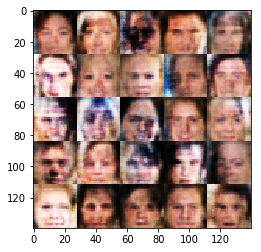

Step:710 Epoch 0/1... Discriminator Loss: 1.1939... Generator Loss: 1.2275
Step:720 Epoch 0/1... Discriminator Loss: 1.2653... Generator Loss: 0.8368
Step:730 Epoch 0/1... Discriminator Loss: 1.1957... Generator Loss: 0.6646
Step:740 Epoch 0/1... Discriminator Loss: 1.7478... Generator Loss: 0.3216
Step:750 Epoch 0/1... Discriminator Loss: 1.0966... Generator Loss: 0.9112
Step:760 Epoch 0/1... Discriminator Loss: 1.1359... Generator Loss: 1.3528
Step:770 Epoch 0/1... Discriminator Loss: 1.1336... Generator Loss: 0.7806
Step:780 Epoch 0/1... Discriminator Loss: 1.1145... Generator Loss: 0.9369
Step:790 Epoch 0/1... Discriminator Loss: 1.1697... Generator Loss: 0.8418
Step:800 Epoch 0/1... Discriminator Loss: 1.1759... Generator Loss: 1.7940


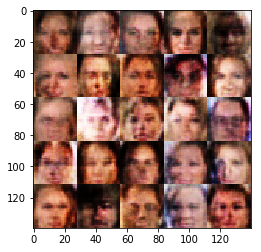

Step:810 Epoch 0/1... Discriminator Loss: 1.2733... Generator Loss: 0.5943
Step:820 Epoch 0/1... Discriminator Loss: 1.2175... Generator Loss: 0.6555
Step:830 Epoch 0/1... Discriminator Loss: 1.1334... Generator Loss: 0.8999
Step:840 Epoch 0/1... Discriminator Loss: 0.9967... Generator Loss: 1.0918
Step:850 Epoch 0/1... Discriminator Loss: 1.0726... Generator Loss: 1.5885
Step:860 Epoch 0/1... Discriminator Loss: 0.9903... Generator Loss: 1.2795
Step:870 Epoch 0/1... Discriminator Loss: 1.2186... Generator Loss: 0.7702
Step:880 Epoch 0/1... Discriminator Loss: 1.1343... Generator Loss: 1.3450
Step:890 Epoch 0/1... Discriminator Loss: 1.2414... Generator Loss: 0.6131
Step:900 Epoch 0/1... Discriminator Loss: 1.2682... Generator Loss: 2.3424


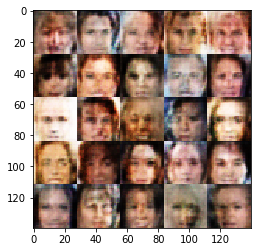

Step:910 Epoch 0/1... Discriminator Loss: 1.0916... Generator Loss: 0.9310
Step:920 Epoch 0/1... Discriminator Loss: 1.1946... Generator Loss: 0.7289
Step:930 Epoch 0/1... Discriminator Loss: 1.1619... Generator Loss: 1.1190
Step:940 Epoch 0/1... Discriminator Loss: 1.2527... Generator Loss: 0.6374
Step:950 Epoch 0/1... Discriminator Loss: 1.4803... Generator Loss: 0.4461
Step:960 Epoch 0/1... Discriminator Loss: 1.2659... Generator Loss: 0.7967
Step:970 Epoch 0/1... Discriminator Loss: 1.2425... Generator Loss: 0.6205
Step:980 Epoch 0/1... Discriminator Loss: 1.1120... Generator Loss: 1.3693
Step:990 Epoch 0/1... Discriminator Loss: 1.0811... Generator Loss: 0.8703
Step:1000 Epoch 0/1... Discriminator Loss: 1.1304... Generator Loss: 1.0273


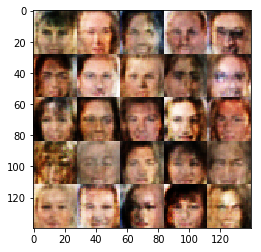

Step:1010 Epoch 0/1... Discriminator Loss: 1.0693... Generator Loss: 1.0471
Step:1020 Epoch 0/1... Discriminator Loss: 1.1951... Generator Loss: 0.6598
Step:1030 Epoch 0/1... Discriminator Loss: 0.9940... Generator Loss: 1.2446
Step:1040 Epoch 0/1... Discriminator Loss: 1.2628... Generator Loss: 0.6129
Step:1050 Epoch 0/1... Discriminator Loss: 1.2934... Generator Loss: 0.5686
Step:1060 Epoch 0/1... Discriminator Loss: 1.1276... Generator Loss: 1.2105
Step:1070 Epoch 0/1... Discriminator Loss: 1.0627... Generator Loss: 0.8998
Step:1080 Epoch 0/1... Discriminator Loss: 1.4008... Generator Loss: 0.4893
Step:1090 Epoch 0/1... Discriminator Loss: 1.1591... Generator Loss: 0.8491
Step:1100 Epoch 0/1... Discriminator Loss: 1.2516... Generator Loss: 0.7092


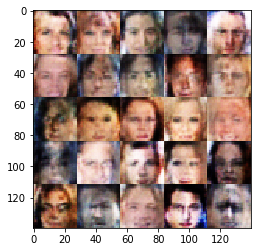

Step:1110 Epoch 0/1... Discriminator Loss: 1.1865... Generator Loss: 1.1683
Step:1120 Epoch 0/1... Discriminator Loss: 1.1887... Generator Loss: 0.7724
Step:1130 Epoch 0/1... Discriminator Loss: 0.9328... Generator Loss: 1.3859
Step:1140 Epoch 0/1... Discriminator Loss: 1.1099... Generator Loss: 0.9690
Step:1150 Epoch 0/1... Discriminator Loss: 1.2125... Generator Loss: 1.0655
Step:1160 Epoch 0/1... Discriminator Loss: 1.0446... Generator Loss: 1.5455
Step:1170 Epoch 0/1... Discriminator Loss: 1.7590... Generator Loss: 0.3215
Step:1180 Epoch 0/1... Discriminator Loss: 1.3927... Generator Loss: 0.5276
Step:1190 Epoch 0/1... Discriminator Loss: 1.1112... Generator Loss: 0.9629
Step:1200 Epoch 0/1... Discriminator Loss: 1.4163... Generator Loss: 0.4687


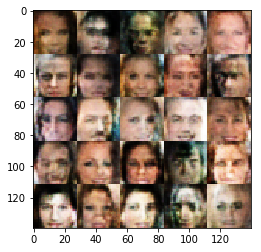

Step:1210 Epoch 0/1... Discriminator Loss: 1.4245... Generator Loss: 0.8803
Step:1220 Epoch 0/1... Discriminator Loss: 1.0610... Generator Loss: 1.0985
Step:1230 Epoch 0/1... Discriminator Loss: 1.4902... Generator Loss: 0.4491
Step:1240 Epoch 0/1... Discriminator Loss: 1.0363... Generator Loss: 1.6045
Step:1250 Epoch 0/1... Discriminator Loss: 0.8870... Generator Loss: 1.3616
Step:1260 Epoch 0/1... Discriminator Loss: 1.2462... Generator Loss: 0.7240
Step:1270 Epoch 0/1... Discriminator Loss: 1.0050... Generator Loss: 0.8982
Step:1280 Epoch 0/1... Discriminator Loss: 1.2181... Generator Loss: 0.6937
Step:1290 Epoch 0/1... Discriminator Loss: 1.1783... Generator Loss: 0.6812
Step:1300 Epoch 0/1... Discriminator Loss: 1.0803... Generator Loss: 1.0109


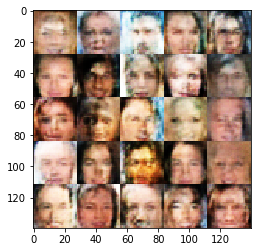

Step:1310 Epoch 0/1... Discriminator Loss: 1.1500... Generator Loss: 0.8425
Step:1320 Epoch 0/1... Discriminator Loss: 1.1204... Generator Loss: 0.8076
Step:1330 Epoch 0/1... Discriminator Loss: 1.7879... Generator Loss: 0.3581
Step:1340 Epoch 0/1... Discriminator Loss: 1.6240... Generator Loss: 0.3759
Step:1350 Epoch 0/1... Discriminator Loss: 1.4369... Generator Loss: 0.4701
Step:1360 Epoch 0/1... Discriminator Loss: 1.2072... Generator Loss: 0.7308
Step:1370 Epoch 0/1... Discriminator Loss: 1.1767... Generator Loss: 0.6670
Step:1380 Epoch 0/1... Discriminator Loss: 0.9514... Generator Loss: 1.8536
Step:1390 Epoch 0/1... Discriminator Loss: 1.5760... Generator Loss: 2.0204
Step:1400 Epoch 0/1... Discriminator Loss: 1.4286... Generator Loss: 0.5627


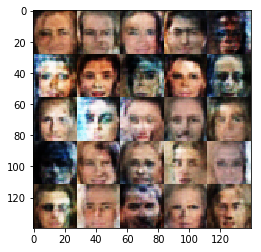

Step:1410 Epoch 0/1... Discriminator Loss: 1.0642... Generator Loss: 0.8761
Step:1420 Epoch 0/1... Discriminator Loss: 0.9967... Generator Loss: 1.1882
Step:1430 Epoch 0/1... Discriminator Loss: 1.0194... Generator Loss: 1.0491
Step:1440 Epoch 0/1... Discriminator Loss: 1.2917... Generator Loss: 0.6557
Step:1450 Epoch 0/1... Discriminator Loss: 1.5331... Generator Loss: 0.4074
Step:1460 Epoch 0/1... Discriminator Loss: 1.3016... Generator Loss: 0.5472
Step:1470 Epoch 0/1... Discriminator Loss: 1.2173... Generator Loss: 0.6622
Step:1480 Epoch 0/1... Discriminator Loss: 1.2861... Generator Loss: 0.5623
Step:1490 Epoch 0/1... Discriminator Loss: 0.8913... Generator Loss: 1.7724
Step:1500 Epoch 0/1... Discriminator Loss: 0.9770... Generator Loss: 0.9942


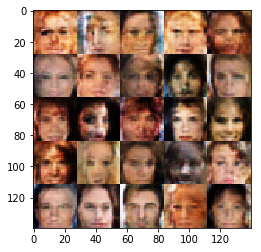

Step:1510 Epoch 0/1... Discriminator Loss: 1.0902... Generator Loss: 0.7499
Step:1520 Epoch 0/1... Discriminator Loss: 1.4236... Generator Loss: 0.5034
Step:1530 Epoch 0/1... Discriminator Loss: 1.1869... Generator Loss: 0.6552
Step:1540 Epoch 0/1... Discriminator Loss: 1.1832... Generator Loss: 0.6697
Step:1550 Epoch 0/1... Discriminator Loss: 1.1116... Generator Loss: 1.0444
Step:1560 Epoch 0/1... Discriminator Loss: 1.7215... Generator Loss: 0.3285
Step:1570 Epoch 0/1... Discriminator Loss: 1.5325... Generator Loss: 0.3990
Step:1580 Epoch 0/1... Discriminator Loss: 1.0719... Generator Loss: 0.8862
Step:1590 Epoch 0/1... Discriminator Loss: 1.1462... Generator Loss: 1.5192
Step:1600 Epoch 0/1... Discriminator Loss: 1.2086... Generator Loss: 0.7428


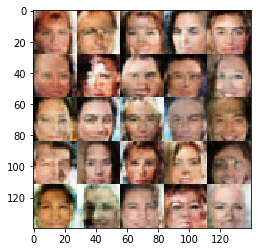

Step:1610 Epoch 0/1... Discriminator Loss: 1.1813... Generator Loss: 1.4836
Step:1620 Epoch 0/1... Discriminator Loss: 1.1591... Generator Loss: 0.6869
Step:1630 Epoch 0/1... Discriminator Loss: 1.0306... Generator Loss: 1.5661
Step:1640 Epoch 0/1... Discriminator Loss: 1.4413... Generator Loss: 0.6864
Step:1650 Epoch 0/1... Discriminator Loss: 1.0853... Generator Loss: 0.9549
Step:1660 Epoch 0/1... Discriminator Loss: 1.2899... Generator Loss: 0.6392
Step:1670 Epoch 0/1... Discriminator Loss: 1.1617... Generator Loss: 0.8600
Step:1680 Epoch 0/1... Discriminator Loss: 1.0913... Generator Loss: 1.8553
Step:1690 Epoch 0/1... Discriminator Loss: 1.2091... Generator Loss: 0.6313
Step:1700 Epoch 0/1... Discriminator Loss: 1.3580... Generator Loss: 0.5167


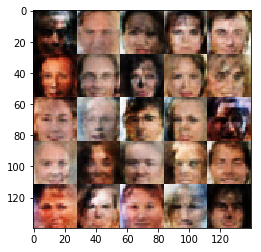

Step:1710 Epoch 0/1... Discriminator Loss: 1.5060... Generator Loss: 0.4299
Step:1720 Epoch 0/1... Discriminator Loss: 1.0537... Generator Loss: 1.0246
Step:1730 Epoch 0/1... Discriminator Loss: 1.2155... Generator Loss: 2.0652
Step:1740 Epoch 0/1... Discriminator Loss: 1.1536... Generator Loss: 0.8970
Step:1750 Epoch 0/1... Discriminator Loss: 1.1147... Generator Loss: 0.8010
Step:1760 Epoch 0/1... Discriminator Loss: 0.9592... Generator Loss: 1.4479
Step:1770 Epoch 0/1... Discriminator Loss: 1.1367... Generator Loss: 0.8854
Step:1780 Epoch 0/1... Discriminator Loss: 1.0788... Generator Loss: 0.8501
Step:1790 Epoch 0/1... Discriminator Loss: 1.4953... Generator Loss: 0.4263
Step:1800 Epoch 0/1... Discriminator Loss: 0.9637... Generator Loss: 1.6318


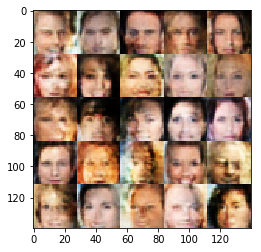

Step:1810 Epoch 0/1... Discriminator Loss: 1.2008... Generator Loss: 0.6380
Step:1820 Epoch 0/1... Discriminator Loss: 1.3899... Generator Loss: 1.5288
Step:1830 Epoch 0/1... Discriminator Loss: 1.0793... Generator Loss: 2.0008
Step:1840 Epoch 0/1... Discriminator Loss: 0.8560... Generator Loss: 1.1016
Step:1850 Epoch 0/1... Discriminator Loss: 0.9698... Generator Loss: 1.1926
Step:1860 Epoch 0/1... Discriminator Loss: 0.9164... Generator Loss: 1.2041
Step:1870 Epoch 0/1... Discriminator Loss: 1.1679... Generator Loss: 1.0696
Step:1880 Epoch 0/1... Discriminator Loss: 1.5035... Generator Loss: 0.4214
Step:1890 Epoch 0/1... Discriminator Loss: 1.0615... Generator Loss: 1.2507
Step:1900 Epoch 0/1... Discriminator Loss: 1.0716... Generator Loss: 1.0804


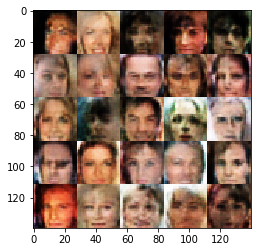

Step:1910 Epoch 0/1... Discriminator Loss: 1.3108... Generator Loss: 0.5510
Step:1920 Epoch 0/1... Discriminator Loss: 1.1573... Generator Loss: 0.6875
Step:1930 Epoch 0/1... Discriminator Loss: 1.0914... Generator Loss: 0.7929
Step:1940 Epoch 0/1... Discriminator Loss: 0.9882... Generator Loss: 1.0660
Step:1950 Epoch 0/1... Discriminator Loss: 1.0839... Generator Loss: 0.7856
Step:1960 Epoch 0/1... Discriminator Loss: 1.1472... Generator Loss: 0.7114
Step:1970 Epoch 0/1... Discriminator Loss: 0.9733... Generator Loss: 1.0021
Step:1980 Epoch 0/1... Discriminator Loss: 1.2469... Generator Loss: 0.5779
Step:1990 Epoch 0/1... Discriminator Loss: 1.3978... Generator Loss: 0.5552
Step:2000 Epoch 0/1... Discriminator Loss: 1.2303... Generator Loss: 0.7858


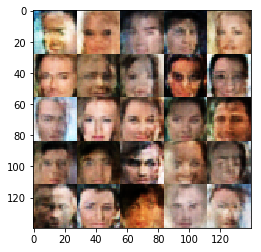

Step:2010 Epoch 0/1... Discriminator Loss: 0.9493... Generator Loss: 1.3475
Step:2020 Epoch 0/1... Discriminator Loss: 1.3521... Generator Loss: 0.5131
Step:2030 Epoch 0/1... Discriminator Loss: 1.0887... Generator Loss: 1.0209
Step:2040 Epoch 0/1... Discriminator Loss: 1.1049... Generator Loss: 0.8709
Step:2050 Epoch 0/1... Discriminator Loss: 1.1468... Generator Loss: 0.7309
Step:2060 Epoch 0/1... Discriminator Loss: 1.3578... Generator Loss: 0.5222
Step:2070 Epoch 0/1... Discriminator Loss: 1.0766... Generator Loss: 0.7727
Step:2080 Epoch 0/1... Discriminator Loss: 0.9956... Generator Loss: 1.1738
Step:2090 Epoch 0/1... Discriminator Loss: 1.0930... Generator Loss: 0.7515
Step:2100 Epoch 0/1... Discriminator Loss: 2.3692... Generator Loss: 2.8844


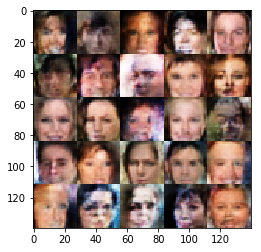

Step:2110 Epoch 0/1... Discriminator Loss: 1.2669... Generator Loss: 0.6047
Step:2120 Epoch 0/1... Discriminator Loss: 1.0545... Generator Loss: 1.2597
Step:2130 Epoch 0/1... Discriminator Loss: 0.9818... Generator Loss: 0.9881
Step:2140 Epoch 0/1... Discriminator Loss: 1.0426... Generator Loss: 0.8790
Step:2150 Epoch 0/1... Discriminator Loss: 1.3664... Generator Loss: 0.5197
Step:2160 Epoch 0/1... Discriminator Loss: 1.2955... Generator Loss: 0.5468
Step:2170 Epoch 0/1... Discriminator Loss: 1.2088... Generator Loss: 0.6467
Step:2180 Epoch 0/1... Discriminator Loss: 1.4093... Generator Loss: 2.0907
Step:2190 Epoch 0/1... Discriminator Loss: 1.8539... Generator Loss: 0.3283
Step:2200 Epoch 0/1... Discriminator Loss: 1.1782... Generator Loss: 1.5692


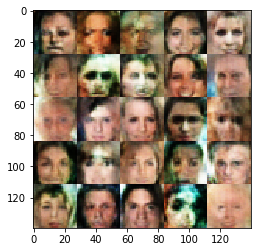

Step:2210 Epoch 0/1... Discriminator Loss: 1.2243... Generator Loss: 0.6922
Step:2220 Epoch 0/1... Discriminator Loss: 1.4148... Generator Loss: 0.5198
Step:2230 Epoch 0/1... Discriminator Loss: 0.9992... Generator Loss: 1.0632
Step:2240 Epoch 0/1... Discriminator Loss: 0.8638... Generator Loss: 1.2623
Step:2250 Epoch 0/1... Discriminator Loss: 1.6228... Generator Loss: 0.3660
Step:2260 Epoch 0/1... Discriminator Loss: 1.0741... Generator Loss: 0.7791
Step:2270 Epoch 0/1... Discriminator Loss: 1.2577... Generator Loss: 0.7624
Step:2280 Epoch 0/1... Discriminator Loss: 1.0320... Generator Loss: 1.0561
Step:2290 Epoch 0/1... Discriminator Loss: 1.0750... Generator Loss: 0.9834
Step:2300 Epoch 0/1... Discriminator Loss: 1.4474... Generator Loss: 0.4546


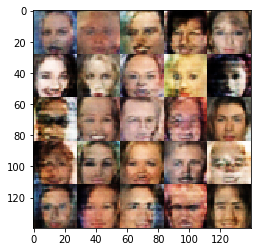

Step:2310 Epoch 0/1... Discriminator Loss: 2.0810... Generator Loss: 0.2353
Step:2320 Epoch 0/1... Discriminator Loss: 1.1689... Generator Loss: 0.7178
Step:2330 Epoch 0/1... Discriminator Loss: 1.0648... Generator Loss: 0.9559
Step:2340 Epoch 0/1... Discriminator Loss: 1.1266... Generator Loss: 0.8560
Step:2350 Epoch 0/1... Discriminator Loss: 0.9790... Generator Loss: 0.9180
Step:2360 Epoch 0/1... Discriminator Loss: 1.0788... Generator Loss: 0.7867
Step:2370 Epoch 0/1... Discriminator Loss: 0.8599... Generator Loss: 1.3674
Step:2380 Epoch 0/1... Discriminator Loss: 1.1150... Generator Loss: 0.8646
Step:2390 Epoch 0/1... Discriminator Loss: 0.8200... Generator Loss: 1.4076
Step:2400 Epoch 0/1... Discriminator Loss: 1.2464... Generator Loss: 0.6070


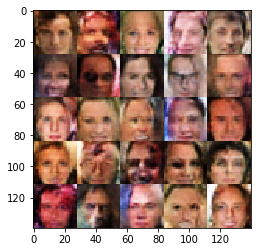

Step:2410 Epoch 0/1... Discriminator Loss: 1.0222... Generator Loss: 1.3538
Step:2420 Epoch 0/1... Discriminator Loss: 1.0882... Generator Loss: 0.7929
Step:2430 Epoch 0/1... Discriminator Loss: 1.3777... Generator Loss: 0.4691
Step:2440 Epoch 0/1... Discriminator Loss: 1.3057... Generator Loss: 0.5507
Step:2450 Epoch 0/1... Discriminator Loss: 1.1341... Generator Loss: 0.7549
Step:2460 Epoch 0/1... Discriminator Loss: 1.0460... Generator Loss: 0.8034
Step:2470 Epoch 0/1... Discriminator Loss: 1.5544... Generator Loss: 0.4038
Step:2480 Epoch 0/1... Discriminator Loss: 0.9905... Generator Loss: 1.0250
Step:2490 Epoch 0/1... Discriminator Loss: 1.4152... Generator Loss: 0.4734
Step:2500 Epoch 0/1... Discriminator Loss: 1.0566... Generator Loss: 1.0963


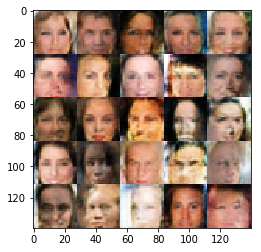

Step:2510 Epoch 0/1... Discriminator Loss: 0.9781... Generator Loss: 0.9602
Step:2520 Epoch 0/1... Discriminator Loss: 1.3860... Generator Loss: 0.4892
Step:2530 Epoch 0/1... Discriminator Loss: 1.5869... Generator Loss: 0.3810
Step:2540 Epoch 0/1... Discriminator Loss: 1.2065... Generator Loss: 0.6564
Step:2550 Epoch 0/1... Discriminator Loss: 1.2623... Generator Loss: 0.6294
Step:2560 Epoch 0/1... Discriminator Loss: 1.0369... Generator Loss: 0.8828
Step:2570 Epoch 0/1... Discriminator Loss: 0.8806... Generator Loss: 0.9709
Step:2580 Epoch 0/1... Discriminator Loss: 1.1890... Generator Loss: 0.9171
Step:2590 Epoch 0/1... Discriminator Loss: 1.1945... Generator Loss: 1.3831
Step:2600 Epoch 0/1... Discriminator Loss: 1.0440... Generator Loss: 0.8120


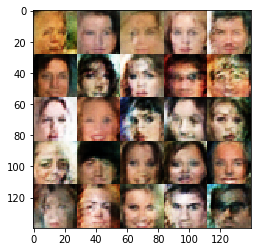

Step:2610 Epoch 0/1... Discriminator Loss: 1.3321... Generator Loss: 0.5203
Step:2620 Epoch 0/1... Discriminator Loss: 0.9172... Generator Loss: 1.7463
Step:2630 Epoch 0/1... Discriminator Loss: 1.4564... Generator Loss: 0.6188
Step:2640 Epoch 0/1... Discriminator Loss: 0.8500... Generator Loss: 1.4181
Step:2650 Epoch 0/1... Discriminator Loss: 0.8842... Generator Loss: 1.2548
Step:2660 Epoch 0/1... Discriminator Loss: 1.1372... Generator Loss: 0.8271
Step:2670 Epoch 0/1... Discriminator Loss: 0.9111... Generator Loss: 1.6341
Step:2680 Epoch 0/1... Discriminator Loss: 1.0855... Generator Loss: 0.7722
Step:2690 Epoch 0/1... Discriminator Loss: 1.0749... Generator Loss: 0.8224
Step:2700 Epoch 0/1... Discriminator Loss: 1.1867... Generator Loss: 1.6162


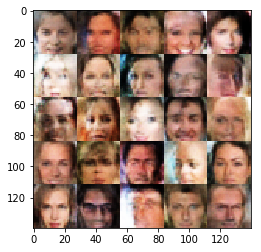

Step:2710 Epoch 0/1... Discriminator Loss: 0.9843... Generator Loss: 1.0405
Step:2720 Epoch 0/1... Discriminator Loss: 1.0148... Generator Loss: 0.9471
Step:2730 Epoch 0/1... Discriminator Loss: 0.8982... Generator Loss: 1.0478
Step:2740 Epoch 0/1... Discriminator Loss: 1.7545... Generator Loss: 0.3341
Step:2750 Epoch 0/1... Discriminator Loss: 1.0298... Generator Loss: 0.8607
Step:2760 Epoch 0/1... Discriminator Loss: 1.4843... Generator Loss: 0.4416
Step:2770 Epoch 0/1... Discriminator Loss: 1.8227... Generator Loss: 0.3033
Step:2780 Epoch 0/1... Discriminator Loss: 1.1461... Generator Loss: 0.6893
Step:2790 Epoch 0/1... Discriminator Loss: 1.1480... Generator Loss: 0.6934
Step:2800 Epoch 0/1... Discriminator Loss: 1.0035... Generator Loss: 1.3868


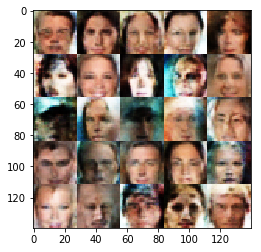

Step:2810 Epoch 0/1... Discriminator Loss: 1.2762... Generator Loss: 0.5621
Step:2820 Epoch 0/1... Discriminator Loss: 1.0119... Generator Loss: 0.9273
Step:2830 Epoch 0/1... Discriminator Loss: 0.9377... Generator Loss: 1.1621
Step:2840 Epoch 0/1... Discriminator Loss: 1.4952... Generator Loss: 0.4633
Step:2850 Epoch 0/1... Discriminator Loss: 1.4082... Generator Loss: 0.4897
Step:2860 Epoch 0/1... Discriminator Loss: 1.1933... Generator Loss: 0.7029
Step:2870 Epoch 0/1... Discriminator Loss: 1.4394... Generator Loss: 0.4528
Step:2880 Epoch 0/1... Discriminator Loss: 1.6440... Generator Loss: 0.4226
Step:2890 Epoch 0/1... Discriminator Loss: 1.3020... Generator Loss: 0.6093
Step:2900 Epoch 0/1... Discriminator Loss: 1.1538... Generator Loss: 0.6876


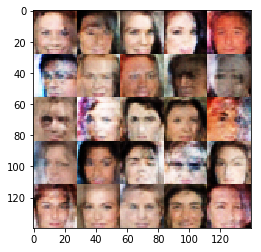

Step:2910 Epoch 0/1... Discriminator Loss: 1.1650... Generator Loss: 0.7275
Step:2920 Epoch 0/1... Discriminator Loss: 1.1089... Generator Loss: 0.8576
Step:2930 Epoch 0/1... Discriminator Loss: 1.3386... Generator Loss: 0.5066
Step:2940 Epoch 0/1... Discriminator Loss: 1.0389... Generator Loss: 0.8338
Step:2950 Epoch 0/1... Discriminator Loss: 1.0863... Generator Loss: 0.9031
Step:2960 Epoch 0/1... Discriminator Loss: 1.6461... Generator Loss: 0.3766
Step:2970 Epoch 0/1... Discriminator Loss: 1.0404... Generator Loss: 1.9832
Step:2980 Epoch 0/1... Discriminator Loss: 1.2547... Generator Loss: 0.5862
Step:2990 Epoch 0/1... Discriminator Loss: 1.0138... Generator Loss: 1.0553
Step:3000 Epoch 0/1... Discriminator Loss: 1.1878... Generator Loss: 0.6371


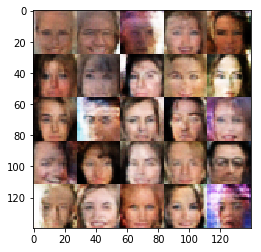

Step:3010 Epoch 0/1... Discriminator Loss: 0.9244... Generator Loss: 1.1318
Step:3020 Epoch 0/1... Discriminator Loss: 1.0620... Generator Loss: 0.7644
Step:3030 Epoch 0/1... Discriminator Loss: 1.1788... Generator Loss: 0.6757
Step:3040 Epoch 0/1... Discriminator Loss: 0.8471... Generator Loss: 1.2445
Step:3050 Epoch 0/1... Discriminator Loss: 1.0563... Generator Loss: 1.3675
Step:3060 Epoch 0/1... Discriminator Loss: 1.4967... Generator Loss: 0.4337
Step:3070 Epoch 0/1... Discriminator Loss: 1.1660... Generator Loss: 0.6805
Step:3080 Epoch 0/1... Discriminator Loss: 1.1790... Generator Loss: 0.6427
Step:3090 Epoch 0/1... Discriminator Loss: 1.4117... Generator Loss: 0.5062
Step:3100 Epoch 0/1... Discriminator Loss: 1.5156... Generator Loss: 0.4077


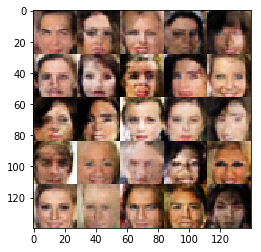

Step:3110 Epoch 0/1... Discriminator Loss: 1.8184... Generator Loss: 0.2971
Step:3120 Epoch 0/1... Discriminator Loss: 0.7543... Generator Loss: 1.4921
Step:3130 Epoch 0/1... Discriminator Loss: 0.9882... Generator Loss: 1.2253
Step:3140 Epoch 0/1... Discriminator Loss: 1.1268... Generator Loss: 0.7031
Step:3150 Epoch 0/1... Discriminator Loss: 1.7627... Generator Loss: 0.3196
Step:3160 Epoch 0/1... Discriminator Loss: 1.3759... Generator Loss: 0.4900


In [16]:
z_dim = 256
learning_rate = 0.0002
batch_size = 64
alpha = 0.2
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.